In [1]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.ticker as ticker
from osgeo import gdal
import salem
from salem import *

import fiona, rasterio
import geopandas as gpd
from rasterio.plot import show
import rasterio.plot as rplt
from rasterio.features import rasterize
from rasterstats import zonal_stats

## input files

In [67]:
# oggm_dem = fl_path+'dem.tif'
# dem_grid = oggm_dem.salem.grid  ##full view
# # H_opt = salem.open_xr_dataset('/home/pelto/oggm_runs/products_opt/Illecillewaet/Illecillewaet101sw_MAE_optimized.nc')
# H_opt = salem.GeoNetcdf('/home/pelto/oggm_runs/products_opt/Illecillewaet/Illecillewaet101sw_MAE_optimized.nc', grid=dem_grid)


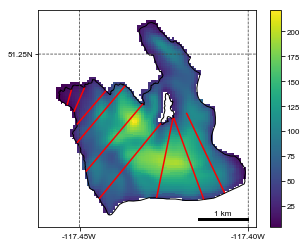

In [63]:
# season
balance = 'bw'  # bw or ba (winter or annual)
rho_snow = 470. # 470 kg m-3 geodetic or 457 glaciological, or...take given years obs. value
year = 2017 # any of: 2016, 2017, 2018

fl_path = '/home/pelto/Desktop/ice_flux/Illecillewaet/'
gpr_path = '/home/pelto/GIS/GPR/ComparisonData/Illec/'
path = '/home/pelto/Desktop/lidar_cbt_analysis/illecillewaet/'
vdir ='img1_20160912__img1_20170917_vmap_5m_35px_spm2/'

vdir1 = '/home/pelto/Desktop/velocity_mapping/illec/spm2/' + vdir

topo = '/home/pelto/Desktop/lidar_cbt_analysis/illecillewaet/160912_illecillewaet_dem1_clip_master.tif'
dh_r = path+ 'illecillewaet_2017_winter_dh_dt_dat1.tif' #'illecillewaet_2017_2016_dh_dt.tif'

pts_file = fl_path + 'Illec_flux_gates_16_pts_20m.shp'  ##must be WGS84 currently
gates = 'Illec_flux_gates_16.shp'
shpf = '/home/pelto/GIS/outlines/Illec2016.shp'   #GLIMS_BC/glims_all/all_glaciers_2016.shp' 
bins=fl_path+'illec_flux_bins.shp'

obs = pd.read_csv(fl_path+ 'illec_bdot.csv')
rho = pd.read_csv(fl_path + 'illec_bins_17.csv')  ## rho

# open GeoTIFF as array
#    msk='conrad_2016_ice_msk_5m_glacieronly.tif'
VX = vdir1 + vdir[:-1] + '-F_vx.tif' 
VY = vdir1+ vdir[:-1] + '-F_vy.tif' 
vx = salem.open_xr_dataset(VX)  #gdal.Open(vx).ReadAsArray()
vy = salem.open_xr_dataset(VY)#gdal.Open(vy).ReadAsArray()
msk = salem.open_xr_dataset(fl_path + 'illec_all_glaciers_2016.tif') 
msk = msk.to_array(name='msk')
gpr = salem.open_xr_dataset(fl_path + 'gpr_outline_50_100m_5m.tif') #'gpr_outlines_all_25_25m_re5m.tif'
# H_opt = salem.GeoNetcdf(opt_path + 'Conrad101sw_MAE_optimized.nc')
H_opt = salem.open_xr_dataset(fl_path + 'Illecillewaet101sw_MAE_optimized.tif') #'Conrad101sw_MAE_optimized.nc'
#     pts = salem.read_shapefile(fl_path+pts)
gates = salem.read_shapefile(fl_path+gates)

vx = vx.to_array(name='vx')
# np.shape(vx[0]) remove index 1 i.e.: 1,2000,3000
vy = vy.to_array(name='vy')
gpr = gpr.to_array(name='gpr')

H_opt_reproj = vx.salem.transform(H_opt)
H_opt = H_opt_reproj.to_array(name='H_opt')


gpr.data[gpr.data<0] = np.nan
gpr.data[gpr.data==1.000] == 0.0   #not having any effect
vx.data[msk.data==0] = np.nan
vy.data[msk.data==0] = np.nan


dem = salem.open_xr_dataset(topo)
dem_reproj = vx.salem.transform(dem)
dem = dem_reproj.to_array(name='dem')
dem.data[dem.data<1] = np.nan

# H_opt_reproj=vx.salem.transform(H_opt)
# H_opt = H_opt_reproj.to_array(name='H_opt')

#     # map extent
grid = mercator_grid(center_ll=(-117.43, 51.238), extent=(4500, 4500)) ##zoomed out view
# grid = vx.salem.grid  ##full view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(H_opt) #, label='m')

#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')


gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1.5, color='r')
sm.visualize()
plt.savefig(fl_path+ 'products/'+ 'illec_thickness_gates.png', dpi=300)
plt.show()

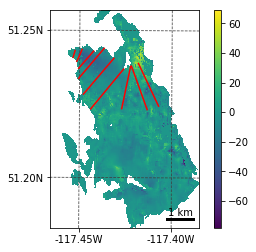

In [28]:
vx = vx.to_array(name='vx')
# np.shape(vx[0]) remove index 1 i.e.: 1,2000,3000
vy = vy.to_array(name='vy')
gpr = gpr.to_array(name='gpr')

H_opt_reproj = vx.salem.transform(H_opt)
H_opt = H_opt_reproj.to_array(name='H_opt')


gpr.data[gpr.data<0] = np.nan
gpr.data[gpr.data==1.000] == 0.0   #not having any effect
vx.data[msk.data==0] = np.nan
vy.data[msk.data==0] = np.nan


dem = salem.open_xr_dataset(topo)
dem_reproj = vx.salem.transform(dem)
dem = dem_reproj.to_array(name='dem')
dem.data[dem.data<1] = np.nan

# H_opt_reproj=vx.salem.transform(H_opt)
# H_opt = H_opt_reproj.to_array(name='H_opt')

#     # map extent
# grid = mercator_grid(center_ll=(-116.94, 50.80), extent=(10000, 9000)) ##zoomed out view
grid = vx.salem.grid  ##full view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(vx)

#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')



gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1.5, color='r')
sm.visualize()
plt.show()

## Functions for calculating zonal statistics over each flux gate bin

In [3]:
# https://community.esri.com/groups/python-snippets/blog/2019/05/07/calculating-zonal-statistics-with-python-rasterstats
# For loading shapefiles into geopandas dataframe

def enum_items(source):
    print("\n")
    for ele in enumerate(source): 
        print(ele)
 
def list_columns(df):
    field_list = list(df)
    enum_items(field_list)
    return field_list

def loadshp_as_gpd(shp):
    data_shp = gpd.read_file(shp)
    return data_shp

# For loading feature classes into geopandas dataframe
def loadfc_as_gpd(fgdb):
    layers = fiona.listlayers(fgdb)
    enum_items(layers)
    index = int(input("Which index to load? "))
    fcgpd = gpd.read_file(fgdb,layer=layers[index])
    return fcgpd

# For re-projecting input vector layer to raster projection
def reproject(fcgpd, raster):
    proj = raster.crs.to_proj4()
    print("Original vector layer projection: ", fcgpd.crs)
    reproj = fcgpd.to_crs(proj)
    print("New vector layer projection (PROJ4): ", reproj.crs)
    fig, ax = plt.subplots(figsize=(15, 15))
    rplt.show(raster, ax=ax)
    reproj.plot(ax=ax, facecolor='none', edgecolor='red')
    fig.show()
    return reproj

def dissolve_gpd(df):
    field_list = list_columns(df)
    index = 1 #int(input("Dissolve by which field (index)? "))
    dgpd = df.dissolve(by=field_list[index])
    return dgpd

# For selecting which raster statistics to calculate
def stats_select():
    stats_list = stats_list = ['min', 'max', 'mean', 'count', 
              'sum', 'std', 'median', 'majority', 
              'minority', 'unique', 'range']
    enum_items(stats_list)
    indices = input("Enter raster statistics selections separated by space: ")
    stats  = list(indices.split())
    out_stats = list()
    for i in stats:
        out_stats.append(stats_list[int(i)])
    return out_stats

def get_zonal_stats(vector, raster, stats):
    # Run zonal statistics, store result in geopandas dataframe
    result = zonal_stats(vector, raster, stats=stats, geojson_out=True)
    geostats = gpd.GeoDataFrame.from_features(result)
    return geostats

## make an ice velocity quiver plot

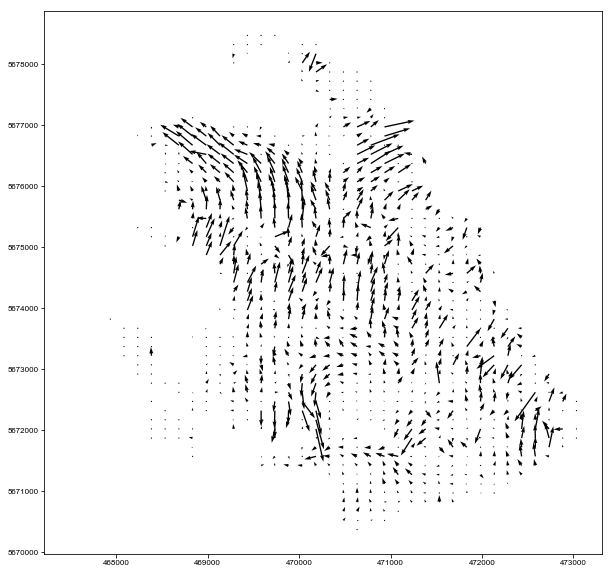

In [42]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

df = salem.read_shapefile(pts_file) ## wgs84'illec_flux_gates_16_pts_20m.shp'

df_file = loadshp_as_gpd(pts_file)
df_file.crs

coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]
# df['lon'] = df[4]
# df['lat'] = df[5]

# ax.scatter(df.lon, df.lat, s=10, c='r' )#c='depth',cmap='viridis', s=10, ax=ax);
# xx, yy = salem.transform_proj(salem.wgs84, grid.proj, df['lon'].values, df['lat'].values)
# df['x'] = xx
# df['y'] = yy

shp_plt = reproject(df, VX)


X, Y = np.meshgrid(vx.coords['x'],vx.coords['y'])
U = vx.data[0]
V = vy.data[0]

# Q = ax.quiver(X, Y, U, V)#units='width', angles='uv') 
Q = ax.quiver(X[::30, ::30], Y[::30, ::30], U[::30, ::30], V[::30, ::30], units='xy')
# ax.set_xlim(502500, 507500)
# ax.set_ylim( 5624000, 5631500)
#     plt.quiver(vx.x, vx.y, vx.data ,vy.data)
# plt.savefig(fl_path+ 'products/'+ 'conrad_16_17_quiver.pdf', dpi=300)

# grid.ij_coordinates
# v_crs = check_crs(vx)

In [6]:
vns = ['vx',
       'vy',
       'gpr',
       'H_opt',
       'dem'
       #'msk',
       ]

In [5]:
# grid = vx.salem.grid  ##full view
# sm = Map(grid, countries=False)
# sm.set_lonlat_contours(interval=0)
# sm.set_scale_bar()
# sm.set_data(vx)

# #      Change the lon-lat countour setting
# sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')


# shpf = '/home/pelto/Desktop/lidar_cbt_analysis/conrad/Conrad/conrad_all_glaciers_2014.shp'
# gdf = salem.read_shapefile(shpf)
# sm.set_shapefile(gdf, linewidth=1)
# sm.set_shapefile(gates, linewidth=1.5, color='r')
# sm.visualize()

In [7]:
vns

['vx', 'vy', 'gpr', 'H_opt', 'dem']

In [8]:
M = xr.merge([vx,vy,gpr,H_opt,dem]) #dem

In [9]:
for vn in vns:
    df[vn] = M[vn][0].interp(x=('z', df.x), y=('z', df.y))

In [165]:
# pts_file = fl_path + 'Illec_flux_gates_16_pts_20m_utm.shp'
# df = salem.read_shapefile(pts_file) ## wgs84'illec_flux_gates_16_pts_20m.shp'

# df_file = loadshp_as_gpd(pts_file)
# shp_crs=df_file.crs
# shp_crs

In [10]:
df

,id,len,distance,angle,geometry,min_x,max_x,min_y,max_y,lon,lat,x,y,vx,vy,gpr,H_opt,dem
0,4,1836.5,0.0,40.448468,POINT (-117.4481437497871 51.22812408699438),-117.448144,-117.448144,51.228124,51.228124,-117.448144,51.228124,468708.453948,5.675289e+06,-1.144019,4.566843,NaN,55.195427,2553.357192
1,4,1836.5,20.0,40.448468,POINT (-117.4479592583071 51.22826165279167),-117.447959,-117.447959,51.228262,51.228262,-117.447959,51.228262,468721.429225,5.675304e+06,0.780996,7.705281,NaN,55.195427,2549.823877
2,4,1836.5,40.0,40.448468,POINT (-117.4477747657278 51.22839921829764),-117.447775,-117.447775,51.228399,51.228399,-117.447775,51.228399,468734.404503,5.675319e+06,1.458560,8.893366,47.084651,67.173894,2544.928728
3,4,1836.5,60.0,40.448468,POINT (-117.4475902720491 51.22853678351225),-117.447590,-117.447590,51.228537,51.228537,-117.447590,51.228537,468747.379780,5.675335e+06,2.959507,11.075131,49.376489,75.314514,2539.381514
4,4,1836.5,80.0,40.448468,POINT (-117.447405777271 51.22867434843553),-117.447406,-117.447406,51.228674,51.228674,-117.447406,51.228674,468760.355057,5.675350e+06,3.496354,12.118198,55.359901,75.314514,2534.969113
5,4,1836.5,100.0,40.448468,POINT (-117.4472212813936 51.22881191306747),-117.447221,-117.447221,51.228812,51.228812,-117.447221,51.228812,468773.330335,5.675365e+06,4.454827,13.742944,64.991546,78.852608,2530.333804
6,4,1836.5,120.0,40.448468,POINT (-117.4470367844168 51.22894947740806),-117.447037,-117.447037,51.228949,51.228949,-117.447037,51.228949,468786.305612,5.675380e+06,4.226677,13.142326,73.070205,88.150208,2526.468915
7,4,1836.5,140.0,40.448468,POINT (-117.4468522863406 51.22908704145728),-117.446852,-117.446852,51.229087,51.229087,-117.446852,51.229087,468799.280890,5.675396e+06,2.042076,8.510769,79.595866,88.150208,2522.477621
8,4,1836.5,160.0,40.448468,POINT (-117.446667787165 51.22922460521517),-117.446668,-117.446668,51.229225,51.229225,-117.446668,51.229225,468812.256167,5.675411e+06,3.426400,8.677508,82.242872,87.283583,2519.042418
9,4,1836.5,180.0,40.448468,POINT (-117.4464832868899 51.22936216868169),-117.446483,-117.446483,51.229362,51.229362,-117.446483,51.229362,468825.231445,5.675426e+06,3.781303,7.901494,81.062704,85.762032,2516.067243


In [12]:
df_agg = df[['id', 'len', 'distance', 'angle', 'geometry', 'lon', 'lat']].copy()
ii, jj = grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = ii
df_agg['j'] = jj
# # We trick by creating an index of similar i's and j's
# df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in (vx.coords['x'], vx.coords['y'])]
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()

In [13]:
# Select
for vn in vns:
#     M_maksed = np.ma.masked_invalid(M[vn][0])
#     df_agg[vn] = .interp(x=('z', df_agg.i), y=('z', df_agg.j))
    df_agg[vn] = M[vn][0].isel(x=('z', df_agg.i), y=('z', df_agg.j))
    


In [10]:
# M.gpr.mean()

In [14]:
D = df_agg[['id', 'len', 'distance', 'angle', 'lon', 'lat', 'vx', 'vy', 'gpr', 'H_opt']].copy()
D

,id,len,distance,angle,lon,lat,vx,vy,gpr,H_opt
ij,,,,,,,,,,
0169_0360,0,329.2,0.0,16.530925,-117.453702,51.240545,NaN,NaN,1.000000,6.393974
0170_0356,0,329.2,20.0,16.530925,-117.453622,51.240718,6.407998,4.000798,23.226000,7.437881
0171_0353,0,329.2,40.0,16.530925,-117.453542,51.240890,6.247455,4.975158,25.458000,7.437881
0172_0349,0,329.2,60.0,16.530925,-117.453463,51.241063,6.336468,4.262638,27.818438,7.437881
0174_0345,0,329.2,80.0,16.530925,-117.453383,51.241236,-0.115401,5.490898,32.694790,12.621210
0175_0341,0,329.2,100.0,16.530925,-117.453303,51.241408,3.799920,2.416204,34.441292,12.621210
0176_0337,0,329.2,120.0,16.530925,-117.453223,51.241581,4.175584,-0.066663,35.254002,14.709440
0177_0333,0,329.2,140.0,16.530925,-117.453143,51.241754,5.396251,-2.728423,35.477245,14.709440
0178_0330,0,329.2,160.0,16.530925,-117.453063,51.241927,-0.806588,0.724846,35.133530,14.709440


In [15]:
import math
D['vz'] = np.sqrt(D.vx**2 + D.vy**2 )  # np.sqrt(U**2 + V**2 )

D['vzdir'] = np.arcsin(D.vx/D.vz) *180/math.pi #degrees from north
D.vzdir[D.vzdir>0.0]=np.nan ## remove false velocity vectors which plague the accumulation zone


#multiply velocity vector by cosine of angle between vector and flux gate (line or line segment)
D['vfg'] = np.abs(D.vz * np.cos((D.vzdir-(D.angle-90.))*(math.pi/180.))) #velocity normal to gate per slice

# D[D.id==0].Qopt = D.vfg * 1.0 * 20. * D.H_opt
# D[D.id==1].Qopt = D.vfg * 1.0 * 20. * D.H_opt

##calculate flux for lowest two bins assuming surface vel. = depth integrated vel.
KP=[]
for loop in D.index:
    ID= D[D.index==loop].id.values
    if ((ID==0) | (ID==1)):
        KP.append( (D[D.index==loop].vfg * 1.0 * 20. * D.H_opt[D.index==loop]).values[0])
    else:
        KP.append((D[D.index==loop].vfg * 0.9 * 20. * D.H_opt[D.index==loop]).values[0])  ## ice flux per slice *0.9 to est. depth-integrated velocity
D['Qopt'] = KP
D['a'] = 20. * D.H_opt #area per slice

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [17]:
D

,id,len,distance,angle,lon,lat,vx,vy,gpr,H_opt,vz,vzdir,vfg,Qopt,a
ij,,,,,,,,,,,,,,,
0169_0360,0,329.2,0.0,16.530925,-117.453702,51.240545,NaN,NaN,1.000000,6.393974,NaN,NaN,NaN,NaN,127.879478
0170_0356,0,329.2,20.0,16.530925,-117.453622,51.240718,6.407998,4.000798,23.226000,7.437881,7.554390,NaN,NaN,NaN,148.757614
0171_0353,0,329.2,40.0,16.530925,-117.453542,51.240890,6.247455,4.975158,25.458000,7.437881,7.986420,NaN,NaN,NaN,148.757614
0172_0349,0,329.2,60.0,16.530925,-117.453463,51.241063,6.336468,4.262638,27.818438,7.437881,7.636813,NaN,NaN,NaN,148.757614
0174_0345,0,329.2,80.0,16.530925,-117.453383,51.241236,-0.115401,5.490898,32.694790,12.621210,5.492110,-1.203992,1.672971,422.298439,252.424194
0175_0341,0,329.2,100.0,16.530925,-117.453303,51.241408,3.799920,2.416204,34.441292,12.621210,4.503047,NaN,NaN,NaN,252.424194
0176_0337,0,329.2,120.0,16.530925,-117.453223,51.241581,4.175584,-0.066663,35.254002,14.709440,4.176116,NaN,NaN,NaN,294.188812
0177_0333,0,329.2,140.0,16.530925,-117.453143,51.241754,5.396251,-2.728423,35.477245,14.709440,6.046802,NaN,NaN,NaN,294.188812
0178_0330,0,329.2,160.0,16.530925,-117.453063,51.241927,-0.806588,0.724846,35.133530,14.709440,1.084428,-48.055340,0.979491,288.155204,294.188812


In [16]:
D[D.index==loop].vfg * 1.0 * 20. * D.H_opt[D.index==loop]

ij
0819_0729   NaN
dtype: float64

In [18]:
Q_out= [0.,] #flux out per gate
cr_area = [0.,] # cross-section area per gate
vzdir = [0.,]

for n in range(D.id.nunique()+1):
        Q_out.append(D.Qopt[D.id==n].sum()) 
        cr_area.append(D.a[D.id==n].sum())
        vzdir.append(D.vzdir[D.id==n].mean())           
Q_in = [Q_out[1:]] #flux in per bin
Q_in = np.squeeze(Q_in)
# Q_in[]



FG = pd.DataFrame(list(zip(Q_out, Q_in, cr_area, vzdir)), columns=['Q_out', 'Q_in', 'cr_area', 'vzdir']) 

FG['vfg'] = FG.Q_out / FG.cr_area #net velocity per gate
FG['bin']=np.arange(0,len(range(D.id.nunique()+1)),1)
FG

,Q_out,Q_in,cr_area,vzdir,vfg,bin
0,0.000000e+00,3.625682e+03,0.000000,0.000000,NaN,0
1,3.625682e+03,1.799903e+05,4793.717285,-34.727295,0.756340,1
2,1.799903e+05,1.114654e+06,12703.967773,-63.521515,14.168034,2
3,1.114654e+06,1.830064e+06,48849.203125,-49.477333,22.818254,3
4,1.830064e+06,4.022060e+06,135301.875000,-47.189762,13.525786,4
5,4.022060e+06,3.137089e+06,234394.625000,-31.800621,17.159351,5
6,3.137089e+06,9.315128e+05,211227.937500,-16.340620,14.851679,6
7,9.315128e+05,5.097539e+04,224668.890625,-16.115475,4.146158,7
8,5.097539e+04,3.602696e+05,218781.328125,-15.523784,0.232997,8
9,3.602696e+05,0.000000e+00,192972.062500,-60.604557,1.866952,9


### import data per bin: height change, elevation, surface area, obs.SMB etc. 

In [ ]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]





In [98]:
M.gpr

<xarray.DataArray 'gpr' (variable: 1, y: 1644, x: 1126)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * x         (x) float64 4.675e+05 4.675e+05 4.675e+05 ... 4.731e+05 4.731e+05
  * y         (y) float64 5.678e+06 5.678e+06 5.678e+06 ... 5.67e+06 5.67e+06
  * variable  (variable) <U4 'data'
Attributes:
    pyproj_srs:  +units=m +init=epsg:32611 

Original vector layer projection:  {'init': 'epsg:32611'}
New vector layer projection (PROJ4):  +init=epsg:2955


/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/matplotlib/image.py:441: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())




(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Enter raster statistics selections separated by space: 2 5 6
Original vector layer projection:  +init=epsg:2955
New vector layer projection (PROJ4):  +init=epsg:2955


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Enter raster statistics selections separated by space: 2 3 5 6
Original vector layer projection:  +init=epsg:2955
New vector layer projection (PROJ4):  +init=epsg:32611


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Enter raster statistics selections separated by space: 2 5 6


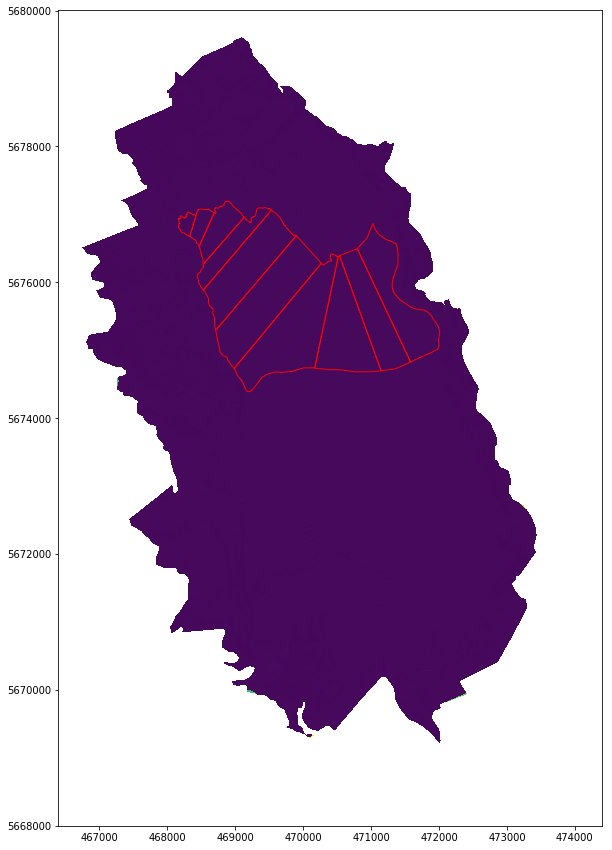

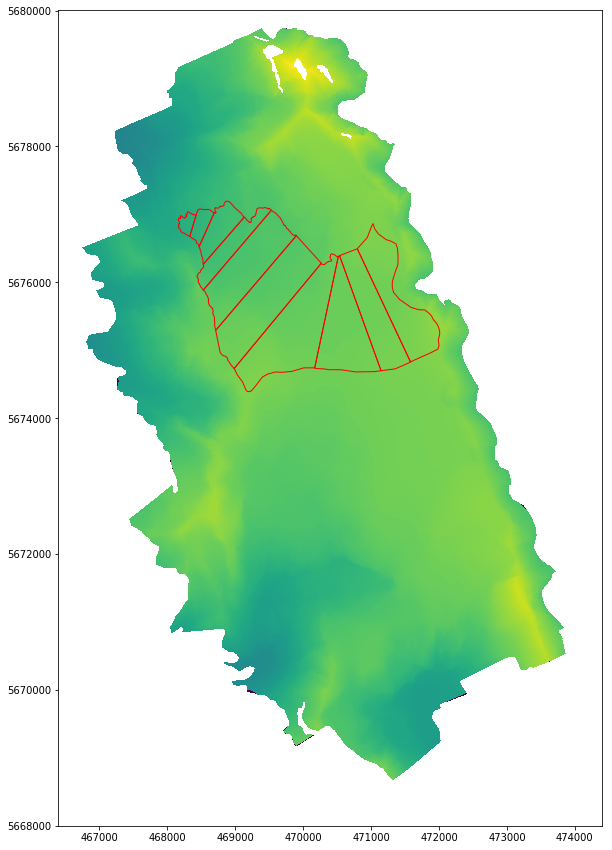

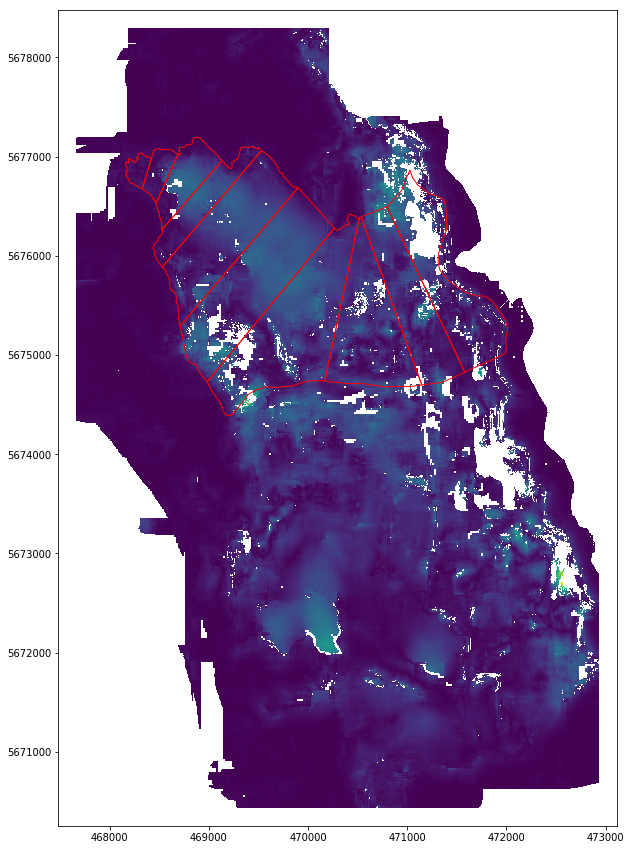

In [19]:
FG_df = FG.copy()
dem_r = topo
vel_r = vdir1 + vdir[:-1] + '-F_vm.tif'
shp = loadshp_as_gpd(bins)

rasters = [dh_r, dem_r, vel_r]
names = ['dh','dem','vm']
for i in range(len(rasters)):
    raster = rasters[i]
    rst = rasterio.open(raster)
    shp = reproject(shp, rst) #shp is in correct projection, trying anyway for calculation
    # dhdt= vx.salem.transform(dhdt)
    name = names[i]
#     shp_vec = dissolve_gpd(shp)  ## only if more columns exist
    stats = stats_select()  #'['min', 'max', 'mean', 'count', 'sum', 'std', 'median', 'majority', 'minority', 'unique', 'range']
    ZS = (get_zonal_stats(shp, raster, stats))
    ZS.drop(['geometry'], axis=1, inplace=True)
    ZS.rename(columns={"mean": name+"_mean", "median":name+"_med", "std": name+"_std"}, inplace=True)
    ZS.sort_values(by=['bin'],ascending=True, inplace=True)
    ZS.set_index('bin', inplace=True)
    FG_df =  pd.concat([FG_df, ZS], axis=1)
    

In [21]:
rho.sort_values(by=['bin'],ascending=True, inplace=True) # sort by bin
rho.set_index('bin', inplace=True) # set bin as index for sorting
rho[0:4]
FG_df =  pd.concat([FG_df, rho], axis=1)
FG_df

,Q_out,Q_in,cr_area,vzdir,vfg,bin,dh_mean,dh_med,dh_std,count,dem_mean,dem_med,dem_std,vm_mean,vm_med,vm_std,rho_17
0,0.000000e+00,3.625682e+03,0.000000,0.000000,NaN,0,4.370694,4.081299,1.574906,56543,2070.356224,2073.121094,24.749604,4.403214,4.610127,1.791896,910
1,3.625682e+03,1.799903e+05,4793.717285,-34.727295,0.756340,1,4.434250,4.393921,1.129010,103478,2148.136145,2147.823730,24.819602,8.139915,5.637404,7.228060,910
2,1.799903e+05,1.114654e+06,12703.967773,-63.521515,14.168034,2,4.385677,4.042114,2.428400,264508,2254.532521,2255.872070,32.210658,19.488606,18.634108,14.631053,910
3,1.114654e+06,1.830064e+06,48849.203125,-49.477333,22.818254,3,3.893007,3.659180,1.468692,320633,2325.707061,2322.538086,30.008066,16.889561,13.261891,12.787306,910
4,1.830064e+06,4.022060e+06,135301.875000,-47.189762,13.525786,4,3.499162,3.449707,0.715877,864047,2395.147486,2390.635742,41.078025,17.775731,16.430992,10.298367,910
5,4.022060e+06,3.137089e+06,234394.625000,-31.800621,17.159351,5,3.292461,3.269043,0.499169,1093091,2479.616134,2460.371582,54.511542,24.443106,26.599785,11.136316,900
6,3.137089e+06,9.315128e+05,211227.937500,-16.340620,14.851679,6,3.326944,3.245117,0.731319,1227849,2547.144009,2532.567871,50.020876,20.339944,19.729391,10.705012,725
7,9.315128e+05,5.097539e+04,224668.890625,-16.115475,4.146158,7,3.056160,3.056396,0.404104,845143,2553.780101,2548.173828,18.234675,15.246895,15.172138,7.332585,600
8,5.097539e+04,3.602696e+05,218781.328125,-15.523784,0.232997,8,2.899150,2.899414,0.102239,672676,2580.431066,2575.529297,20.373179,16.916582,14.395066,11.425853,600
9,3.602696e+05,0.000000e+00,192972.062500,-60.604557,1.866952,9,3.027701,2.963623,0.279394,833818,2620.909676,2621.461182,33.656198,16.048907,11.889656,12.614652,650


In [20]:
rho

,bin,rho_17
0,0,910
1,1,910
2,2,910
3,3,910
4,4,910
5,5,900
6,6,725
7,7,600
8,8,600
9,9,650


In [22]:
FG_df['Q_net'] = FG_df.Q_in - FG_df.Q_out  #net flux per gate
FG_df['Q_netA']= FG_df.Q_net / FG_df['count']
FG_df['b_fg_h'] = FG_df.dh_mean - FG_df.Q_netA
if balance == 'bw':
    FG_df['b_fg_we'] = rho_snow/1000. * FG_df.b_fg_h
else:
    FG_df['b_fg_we'] = FG_df.rho_17/1000. * FG_df.b_fg_h
# FG_df.drop(FG_df.tail(1).index,inplace=True)
FG_df

,Q_out,Q_in,cr_area,vzdir,vfg,bin,dh_mean,dh_med,dh_std,count,...,dem_med,dem_std,vm_mean,vm_med,vm_std,rho_17,Q_net,Q_netA,b_fg_h,b_fg_we
0,0.000000e+00,3.625682e+03,0.000000,0.000000,NaN,0,4.370694,4.081299,1.574906,56543,...,2073.121094,24.749604,4.403214,4.610127,1.791896,910,3.625682e+03,0.064123,4.306572,2.024089
1,3.625682e+03,1.799903e+05,4793.717285,-34.727295,0.756340,1,4.434250,4.393921,1.129010,103478,...,2147.823730,24.819602,8.139915,5.637404,7.228060,910,1.763646e+05,1.704368,2.729882,1.283045
2,1.799903e+05,1.114654e+06,12703.967773,-63.521515,14.168034,2,4.385677,4.042114,2.428400,264508,...,2255.872070,32.210658,19.488606,18.634108,14.631053,910,9.346632e+05,3.533592,0.852086,0.400480
3,1.114654e+06,1.830064e+06,48849.203125,-49.477333,22.818254,3,3.893007,3.659180,1.468692,320633,...,2322.538086,30.008066,16.889561,13.261891,12.787306,910,7.154107e+05,2.231245,1.661763,0.781028
4,1.830064e+06,4.022060e+06,135301.875000,-47.189762,13.525786,4,3.499162,3.449707,0.715877,864047,...,2390.635742,41.078025,17.775731,16.430992,10.298367,910,2.191995e+06,2.536894,0.962268,0.452266
5,4.022060e+06,3.137089e+06,234394.625000,-31.800621,17.159351,5,3.292461,3.269043,0.499169,1093091,...,2460.371582,54.511542,24.443106,26.599785,11.136316,900,-8.849701e+05,-0.809603,4.102064,1.927970
6,3.137089e+06,9.315128e+05,211227.937500,-16.340620,14.851679,6,3.326944,3.245117,0.731319,1227849,...,2532.567871,50.020876,20.339944,19.729391,10.705012,725,-2.205577e+06,-1.796293,5.123237,2.407922
7,9.315128e+05,5.097539e+04,224668.890625,-16.115475,4.146158,7,3.056160,3.056396,0.404104,845143,...,2548.173828,18.234675,15.246895,15.172138,7.332585,600,-8.805374e+05,-1.041880,4.098040,1.926079
8,5.097539e+04,3.602696e+05,218781.328125,-15.523784,0.232997,8,2.899150,2.899414,0.102239,672676,...,2575.529297,20.373179,16.916582,14.395066,11.425853,600,3.092942e+05,0.459797,2.439354,1.146496
9,3.602696e+05,0.000000e+00,192972.062500,-60.604557,1.866952,9,3.027701,2.963623,0.279394,833818,...,2621.461182,33.656198,16.048907,11.889656,12.614652,650,-3.602696e+05,-0.432072,3.459774,1.626094


In [23]:
D['Agpr']=np.NaN
D.sort_values(by=['distance'],ascending=True, inplace=True) 
for n in range(D.id.nunique()):

    for c in range(D.id[D.id==n].count()-1):
        idx=D[(D.id==n)&(D.distance==D[D.id==n].distance[c])].index
        
        if c==0:
            G= D.distance[D.id==n][c+1] - D.distance[D.id==n][c] * D.gpr[D.id==n][c+1]*0.5 #area of triangle
        elif c==1:
            G= (D.distance[D.id==n][c+1] - D.distance[D.id==n][c])/2 * D.gpr[D.id==n][c]
        elif c==len(D.id[D.id==n])-2: #
            G= (D.distance[D.id==n][c] - D.distance[D.id==n][c-1])/2 * D.gpr[D.id==n]
        elif c==len(D.id[D.id==n])-1:  #last point in line
            G= D.distance[D.id==n][c] + D.distance[D.id==n][c+1] * D.gpr[D.id==n][c-1]*0.5 #area of triangle
        else:
            G=(((D.distance[D.id==n][c+1]-D.distance[D.id==n][c])/2) + ((D.distance[D.id==n][c] -
                    D.distance[D.id==n][c-1])/2))* D.gpr[D.id==n][c]  
       
        D.loc[idx,'Agpr']= G
#         D['Q_gpr'] = (D.vfg * 0.9 *D['Agpr'])
#     D['A'] = D.vfg[D.id==n] * D.gpr[D.id==n]

#calculate flux out using GPR thicknesses
D['Qo_gpr'] = D.Agpr * D.vfg * 0.9

In [24]:
# D.to_csv(fl_path+'conrad_junk.csv')

In [25]:
for i in range(len(range(D.id.nunique()+1))):
    print(i, D.Agpr[D.id==i].mean())

0 597.3336446285248
1 877.505849202474
2 1120.8037002563476
3 1692.5814159711201
4 1890.30317735672
5 2708.9424641927085
6 2682.3796021310905
7 2574.892764424169
8 2609.151327643596
9 nan


In [26]:
Qo_gpr = [0.,] #flux out per gate
cr_area_gpr = [0.,] # cross-section area per gate
vzdir_gpr = [0.,]
n=0
for n in range(D.id.nunique()):
        Qo_gpr.append(D.Qo_gpr[D.id==n].sum()) 
        cr_area_gpr.append(D.Agpr[D.id==n].sum())
        vzdir_gpr.append(D.vzdir[D.id==n].mean())           
Qin_gpr = [Qo_gpr[1:]+ [0.0]] #flux in per bin, add zero to end for top bin (for now)
Qin_gpr = np.squeeze(Qin_gpr)

In [27]:
FG_gpr = pd.DataFrame(list(zip(Qo_gpr, Qin_gpr, cr_area_gpr)), columns=['Qo_gpr', 'Qin_gpr', 'cr_area_gpr']) 
FG_gpr['bin'] = np.arange(0,len(range(D.id.nunique()+1)),1)#[0,1,2,3]
# FG_gpr['vfg'] = FG_gpr.Qo_gpr / FG_gpr.cr_area_gpr #net velocity per gate
# FG['bin']=np.arange(0,14,1)
FG_gpr

,Qo_gpr,Qin_gpr,cr_area_gpr,bin
0,0.000000e+00,6.870883e+03,0.000000,0
1,6.870883e+03,1.723355e+05,9557.338314,1
2,1.723355e+05,8.291207e+05,13162.587738,2
3,8.291207e+05,1.465180e+06,39228.129509,3
4,1.465180e+06,2.860306e+06,81243.907967,4
5,2.860306e+06,1.244452e+06,151224.254189,5
6,1.244452e+06,1.731260e+05,65014.619141,6
7,1.731260e+05,6.063954e+04,101930.424881,7
8,6.063954e+04,4.954133e+05,221440.777740,8
9,4.954133e+05,0.000000e+00,185249.744263,9


In [180]:
# for i in range(7):
#     print(i, np.nanmean(D.vzdir[D.id==i]))

In [28]:
FG_df

,Q_out,Q_in,cr_area,vzdir,vfg,bin,dh_mean,dh_med,dh_std,count,...,dem_med,dem_std,vm_mean,vm_med,vm_std,rho_17,Q_net,Q_netA,b_fg_h,b_fg_we
0,0.000000e+00,3.625682e+03,0.000000,0.000000,NaN,0,4.370694,4.081299,1.574906,56543,...,2073.121094,24.749604,4.403214,4.610127,1.791896,910,3.625682e+03,0.064123,4.306572,2.024089
1,3.625682e+03,1.799903e+05,4793.717285,-34.727295,0.756340,1,4.434250,4.393921,1.129010,103478,...,2147.823730,24.819602,8.139915,5.637404,7.228060,910,1.763646e+05,1.704368,2.729882,1.283045
2,1.799903e+05,1.114654e+06,12703.967773,-63.521515,14.168034,2,4.385677,4.042114,2.428400,264508,...,2255.872070,32.210658,19.488606,18.634108,14.631053,910,9.346632e+05,3.533592,0.852086,0.400480
3,1.114654e+06,1.830064e+06,48849.203125,-49.477333,22.818254,3,3.893007,3.659180,1.468692,320633,...,2322.538086,30.008066,16.889561,13.261891,12.787306,910,7.154107e+05,2.231245,1.661763,0.781028
4,1.830064e+06,4.022060e+06,135301.875000,-47.189762,13.525786,4,3.499162,3.449707,0.715877,864047,...,2390.635742,41.078025,17.775731,16.430992,10.298367,910,2.191995e+06,2.536894,0.962268,0.452266
5,4.022060e+06,3.137089e+06,234394.625000,-31.800621,17.159351,5,3.292461,3.269043,0.499169,1093091,...,2460.371582,54.511542,24.443106,26.599785,11.136316,900,-8.849701e+05,-0.809603,4.102064,1.927970
6,3.137089e+06,9.315128e+05,211227.937500,-16.340620,14.851679,6,3.326944,3.245117,0.731319,1227849,...,2532.567871,50.020876,20.339944,19.729391,10.705012,725,-2.205577e+06,-1.796293,5.123237,2.407922
7,9.315128e+05,5.097539e+04,224668.890625,-16.115475,4.146158,7,3.056160,3.056396,0.404104,845143,...,2548.173828,18.234675,15.246895,15.172138,7.332585,600,-8.805374e+05,-1.041880,4.098040,1.926079
8,5.097539e+04,3.602696e+05,218781.328125,-15.523784,0.232997,8,2.899150,2.899414,0.102239,672676,...,2575.529297,20.373179,16.916582,14.395066,11.425853,600,3.092942e+05,0.459797,2.439354,1.146496
9,3.602696e+05,0.000000e+00,192972.062500,-60.604557,1.866952,9,3.027701,2.963623,0.279394,833818,...,2621.461182,33.656198,16.048907,11.889656,12.614652,650,-3.602696e+05,-0.432072,3.459774,1.626094


In [29]:
FG_all = FG_df.merge(FG_gpr, how='left') #on='bin')  

In [182]:
FG_df = FG.copy()
FG_df

,Q_out,Q_in,cr_area,vzdir,vfg,bin
0,0.000000e+00,3.263113e+03,0.000000,0.000000,NaN,0
1,3.263113e+03,1.619912e+05,4793.717285,-34.727295,0.680706,1
2,1.619912e+05,1.114654e+06,12703.967773,-63.521515,12.751231,2
3,1.114654e+06,1.830064e+06,48849.203125,-49.477333,22.818254,3
4,1.830064e+06,4.022060e+06,135301.875000,-47.189762,13.525786,4
5,4.022060e+06,3.137089e+06,234394.625000,-31.800621,17.159351,5
6,3.137089e+06,9.315128e+05,211227.937500,-16.340620,14.851679,6
7,9.315128e+05,5.097539e+04,224668.890625,-16.115475,4.146158,7
8,5.097539e+04,3.602696e+05,218781.328125,-15.523784,0.232997,8
9,3.602696e+05,0.000000e+00,192972.062500,-60.604557,1.866952,9


In [30]:
FG_all

,Q_out,Q_in,cr_area,vzdir,vfg,bin,dh_mean,dh_med,dh_std,count,...,vm_med,vm_std,rho_17,Q_net,Q_netA,b_fg_h,b_fg_we,Qo_gpr,Qin_gpr,cr_area_gpr
0,0.000000e+00,3.625682e+03,0.000000,0.000000,NaN,0,4.370694,4.081299,1.574906,56543,...,4.610127,1.791896,910,3.625682e+03,0.064123,4.306572,2.024089,0.000000e+00,6.870883e+03,0.000000
1,3.625682e+03,1.799903e+05,4793.717285,-34.727295,0.756340,1,4.434250,4.393921,1.129010,103478,...,5.637404,7.228060,910,1.763646e+05,1.704368,2.729882,1.283045,6.870883e+03,1.723355e+05,9557.338314
2,1.799903e+05,1.114654e+06,12703.967773,-63.521515,14.168034,2,4.385677,4.042114,2.428400,264508,...,18.634108,14.631053,910,9.346632e+05,3.533592,0.852086,0.400480,1.723355e+05,8.291207e+05,13162.587738
3,1.114654e+06,1.830064e+06,48849.203125,-49.477333,22.818254,3,3.893007,3.659180,1.468692,320633,...,13.261891,12.787306,910,7.154107e+05,2.231245,1.661763,0.781028,8.291207e+05,1.465180e+06,39228.129509
4,1.830064e+06,4.022060e+06,135301.875000,-47.189762,13.525786,4,3.499162,3.449707,0.715877,864047,...,16.430992,10.298367,910,2.191995e+06,2.536894,0.962268,0.452266,1.465180e+06,2.860306e+06,81243.907967
5,4.022060e+06,3.137089e+06,234394.625000,-31.800621,17.159351,5,3.292461,3.269043,0.499169,1093091,...,26.599785,11.136316,900,-8.849701e+05,-0.809603,4.102064,1.927970,2.860306e+06,1.244452e+06,151224.254189
6,3.137089e+06,9.315128e+05,211227.937500,-16.340620,14.851679,6,3.326944,3.245117,0.731319,1227849,...,19.729391,10.705012,725,-2.205577e+06,-1.796293,5.123237,2.407922,1.244452e+06,1.731260e+05,65014.619141
7,9.315128e+05,5.097539e+04,224668.890625,-16.115475,4.146158,7,3.056160,3.056396,0.404104,845143,...,15.172138,7.332585,600,-8.805374e+05,-1.041880,4.098040,1.926079,1.731260e+05,6.063954e+04,101930.424881
8,5.097539e+04,3.602696e+05,218781.328125,-15.523784,0.232997,8,2.899150,2.899414,0.102239,672676,...,14.395066,11.425853,600,3.092942e+05,0.459797,2.439354,1.146496,6.063954e+04,4.954133e+05,221440.777740
9,3.602696e+05,0.000000e+00,192972.062500,-60.604557,1.866952,9,3.027701,2.963623,0.279394,833818,...,11.889656,12.614652,650,-3.602696e+05,-0.432072,3.459774,1.626094,4.954133e+05,0.000000e+00,185249.744263


In [31]:
FG_all['Q_net_gpr'] = FG_all.Qin_gpr - FG_all.Qo_gpr 
FG_all['Q_netA_gpr']= FG_all.Q_net_gpr / FG_all['count'] 
FG_all['b_fg_h_gpr'] = FG_all.dh_mean - FG_all.Q_netA_gpr  #dh1516_mean
if balance == 'bw':
    FG_all['b_fg_we_gpr'] = rho_snow/1000. * FG_all.b_fg_h_gpr
else:
    FG_all['b_fg_we_gpr'] = FG_all.rho_17/1000. * FG_all.b_fg_h_gpr
# FG_all.drop(FG_all.tail(1).index,inplace=True)
FG_all['dem_mean']

0    2070.356224
1    2148.136145
2    2254.532521
3    2325.707061
4    2395.147486
5    2479.616134
6    2547.144009
7    2553.780101
8    2580.431066
9    2620.909676
Name: dem_mean, dtype: float64

## Plot balance gradients

In [32]:
from scipy import stats
# import pylab

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

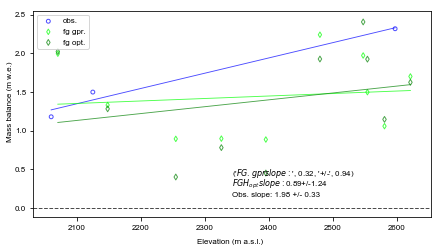

In [33]:
from scipy import stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import statsmodels.api as stm


font = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 8}

plt.rc('font', **font)

fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(6,3.34))#3.34, 3.34))
# j,k=0,0    ## only define j if one row
n = 0
s= 15 #markersize

a = 0.7
color=['b', 'lime', 'green']
year = 2017
##all_obs
if balance == 'bw':
    obs = obs.dropna(subset=['Bw'])
    y_ax_obs=obs[(obs.Year==year)].Bw

else:
    obs = obs.dropna(subset=['Ba'])
    y_ax_obs=obs[(obs.Year==year)].Ba


x_ax_obs=obs[(obs.Year==year)].Elev
##obs by bin
# x_ax_obs=FG_df._elevmean  #FG_df.elev_mean
# y_ax_obs=FG_df.b_obs16#b_obs

# Drop unrealistic FG smb:
new = FG_all.copy()

new = new[new.b_fg_we >-8.]
new = new[new.b_fg_we_gpr >-8.]
 
x_ax_fg_gpr=new.dem_mean
y_ax_fg_gpr=new.b_fg_we_gpr

x_ax_fg_opt=new.dem_mean  #FG_df.elev_mean
y_ax_fg_opt=new.b_fg_we

# for i in range(3):
#     x = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt]
#     y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt]
#     fit = np.polyfit(x[i],y[i],2)
#     y_new = np.polyval(fit,x[i])
#     ax.plot(x[i],y_new,c=color[i], linewidth=1.0, linestyle='--', alpha=a-0.1)

### observations of SMB
slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(x_ax_obs),np.array(y_ax_obs))
ax.scatter(x_ax_obs,y_ax_obs,color='b', label='obs.', alpha=a, s=s,facecolor='')
ax.plot(x_ax_obs,slope*x_ax_obs+intercept, color='b',label='', alpha=a, linewidth=0.9)

slopeG, interceptG, r_valueG, p_valueG, std_errG = stats.linregress(np.array(x_ax_fg_gpr),np.array(y_ax_fg_gpr))
ax.scatter(x_ax_fg_gpr,y_ax_fg_gpr,color='lime', label='fg gpr.', alpha=a, s=s,facecolor='', marker='d')
ax.plot(x_ax_fg_gpr,slopeG*x_ax_fg_gpr+interceptG, color='lime',label='', alpha=a, linewidth=0.9)

# X = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt]
# Y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt]
# out=[]
# for i in range(3):
#      ## X usually means our input variables (or independent variables)
#      ## Y usually means our output/dependent variable
#     X_new = stm.add_constant(X[i]) ## let's add an intercept (beta_0) to our model
#     mod = stm.OLS(Y[i], X_new).fit()   #FG_all.b_fg_we_gpr, FG_all._elevmean) # stm.OLS(output, input)
#     predictions = mod.predict(X_new)
#     out.append(np.round(1000*mod.bse[1],2) )





#         ### flux gate from GPR thickness
#         slopeM, interceptM, r_valueM, p_valueM, std_errM = stats.linregress(np.array(x_ax_fg),np.array(y_ax_fg))
#         ax.scatter(x_ax_fg,y_ax_fg,color='r', label='fgel', alpha=a, s=s+2, facecolor='')
#         ax.plot(x_ax_fg,slopeM*x_ax_fg+interceptM, color='r', label='', alpha=a, linewidth=0.9)
#         ax.text(0.5, 0.1, ['$obs. slope:$', np.round(slope,4)], transform=ax.transAxes)
#         ax.text(0.5, 0.2, ['$FG. slope:$', np.round(slopeM,4)], transform=ax.transAxes)

#         ax.text(0.05, 0.9, year[n], transform=ax.transAxes, fontweight='bold')

###flux gate from optimized thickness
slopeM_opt, interceptM_opt, r_valueM_opt, p_valueM_opt, std_errM_opt = stats.linregress(np.array(
    x_ax_fg_opt),np.array(y_ax_fg_opt))
ax.scatter(x_ax_fg_opt,y_ax_fg_opt,color='g', label='fg opt.', alpha=a, s=s+2, facecolor='', marker='d')
ax.plot(x_ax_fg_opt,slopeM_opt*x_ax_fg_opt+interceptM_opt, color='g', label='', alpha=a, linewidth=0.9)
ax.axhline(linewidth=1, color='k', ls='--', alpha=a, zorder=0)

# ax.text(0.05, 0.9, 'All', transform=ax.transAxes, fontweight='bold')
txt='Obs. slope: ' + str(np.round(1000*slope,2))+ ' +/- ' + str(np.round(1000*std_err,2))
# txtO=
# txtG=
ax.text(0.5, 0.1, txt, transform=ax.transAxes)
ax.text(0.5, 0.15, (str('$FG ' + 'H_{opt}''slope:$')+ str(np.round(1000*slopeM_opt,2))+ '+/-' + str(np.round(1000*std_errM_opt,2))), transform=ax.transAxes)
ax.text(0.5, 0.2, ('$FG. gpr slope:$', np.round(1000*slopeG,2),'+/-', np.round(1000*std_errG,2)), transform=ax.transAxes)
#'$\frac{+}{-}$'

fig.subplots_adjust(bottom=0.12, top=0.98, hspace=0.1, left=0.07, right=0.99, wspace=0.05)#left=0.07, right=0.9,wspace=0.05, 
ax.legend(loc='best')#, bbox_to_anchor=(0, 0.42, 0.7, 0.5), labelspacing=0.2, handletextpad=0.1)
fig.text(0.01, 0.75, 'Mass balance (m w.e.)', rotation=90)
fig.text(0.45, 0.01, 'Elevation (m a.s.l.)')

plt.savefig(fl_path + 'products/' + 'illec_bdot_' + balance + str(year) +'.png', dpi=300) #+ Glacier[gl]

plt.show()

## Plot flux gates as cross-sections

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


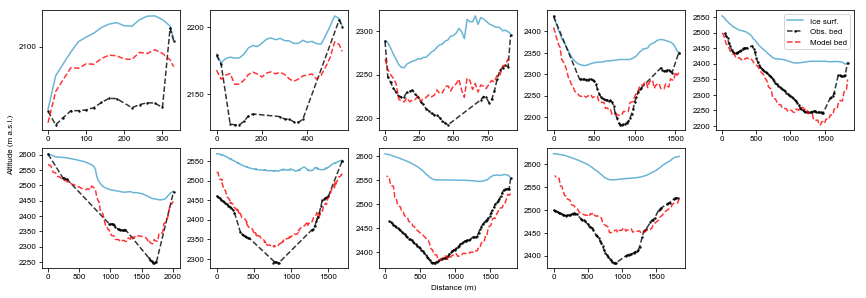

In [36]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='2'
pylab.rcParams['ytick.major.pad']='2'

j,k = 0,0
n=0
# df_agg['area_opt'] = df_agg.thick_opt * 10 
a=0.8
letter='a','b','c','d'

obs_H = df_agg.copy()
# obs_H.gpr[obs_H.id==6]=np.nan
obs_H = obs_H.dropna(subset=['gpr'])   #[obs_H.gpr != np.nan]


fig, ax = plt.subplots(2,5, figsize=(12,4))
for i in range(D.id.nunique()):
    
    # plot glacier surface
    ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem), color='#43a2ca', alpha=a, label='Ice surf.')
    
    #plot gpr thickness gates
    gpr=(obs_H[obs_H.id==i].dem)-(obs_H[obs_H.id==i].gpr)
    gpr_mask=np.isfinite(gpr)
    ax[j,k].plot(obs_H[obs_H.id==i].distance, gpr, marker='o'
                 , ms=1.5, ls='--', color='k', alpha=a, label='Obs. bed')
    
#         ax[j,k].set_ylim(((df_agg.elev[df_agg.id_opt==i])-(df_agg[df_agg.id_opt==i].thick_opt)+5).max(), -5)
    
    ##plot optimized thickness gates
    ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem)-(df_agg[df_agg.id==i].H_opt), 
                 ls='--', c='r', alpha=a, label='Model bed')  #marker='o')
    ax[1,4].axis('off')
    ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(50)) ##
#     ax[j,k].text(0.05, 0.05, letter[i], transform=ax[j,k].transAxes, fontweight='bold', fontsize=10, verticalalignment='center', horizontalalignment='center',)
    n += 1

    k += 1
    if n == 5: 
        j += 1
        k = 0  
         
    ax[0,4].legend(loc=1)
      
fig.text(0.01, 0.6, 'Altitude (m a.s.l.)', rotation=90)
fig.text(0.5, 0.01, 'Distance (m)')     
fig.subplots_adjust(bottom=0.085, top=0.98, left=0.05, right=0.99, wspace=0.22, hspace=0.15) 
plt.savefig(fl_path + 'products/' + 'Illec_flux_gates.png', dpi=300)
plt.show()

# for i in range(4):
#     area=df_agg[df_agg.id_opt==i].area_opt
#     area_total = area.sum()
#     print(area_total)        

In [53]:
obs

,ID,E,N,Elev,Bw,Bs,Ba,Year
1,70,471018.0,5674714.0,2597,2.32,-1.23,1.09,2017
7,30,468401.0,5676793.0,2125,1.50,-6.66,-5.15,2017
8,20,468235.0,5676857.0,2060,1.18,-6.67,-5.50,2017
